<a href="https://colab.research.google.com/github/ricardobizerra/custom-mlp/blob/main/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IF867 - Introdução à Aprendizagem Profunda
### 1ª atividade prática

Discente(s): Ricardo Bizerra de Lima Filho (rblf)

Período: 2024.2

## Instruções e Requisitos
- Objetivo: Implementar e treinar um Multilayer Perceptron (MLP), inteiramente em [NumPy](https://numpy.org/doc/stable/) ou [Numba](https://numba.readthedocs.io/en/stable/index.html), sem o uso de bibliotecas de aprendizado profundo.
- A atividade pode ser feita em dupla.

### Tarefas

__Implementação (50%):__

- Construa um MLP com uma camada de entrada, pelo menos duas camadas ocultas e uma camada de saída.
- Implemente pelo menos duas funções de ativação diferentes para as camadas ocultas; use Sigmoid e Linear para a camada de saída.
- Implemente forward e backpropagation.
- Implemente um otimizador de sua escolha, adequado ao problema abordado.
- Implemente as funções de treinamento e avaliação.

__Aplicação (30%):__

  Teste se os seus modelos estão funcionando bem com as seguintes tarefas:
  - Regressão
  - Classificação binária

__Experimentação (20%):__

  Teste os seus modelos com variações na arquitetura, no pré-processamento, etc. Escolha pelo menos uma das seguintes opções:
  - Variações na inicialização de pesos
  - Variações na arquitetura
  - Implementação de técnicas de regularização
  - Visualização das ativações e gradientes

***Bônus:*** Implemente o MLP utilizando uma biblioteca de machine learning (ex.: [PyTorch](https://pytorch.org/), [TensorFlow](https://www.tensorflow.org/?hl=pt-br), [tinygrad](https://docs.tinygrad.org/), [Jax](https://jax.readthedocs.io/en/latest/quickstart.html)) e teste-o em uma das aplicações e em um dos experimentos propostos. O bônus pode substituir um dos desafios de aplicação ou experimentos feitos em NumPy, ou simplesmente somar pontos para a pontuação geral.

### Datasets recomendados:
Aqui estão alguns datasets recomendados, mas fica a cargo do aluno escolher os datasets que utilizará na atividade, podendo escolher um dataset não listado abaixo.
- Classificação

  - [Iris](https://archive.ics.uci.edu/dataset/53/iris)
  - [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)
  - [CDC Diabetes Health Indicators](https://archive.ics.uci.edu/dataset/891/cdc+diabetes+health+indicators)

- Regressão

  - [Air Quality](https://archive.ics.uci.edu/dataset/360/air+quality)
  - [Student Performance](https://archive.ics.uci.edu/dataset/320/student+performance)
  - [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality)

### Requisitos para Entrega

Um notebook Jupyter (de preferência, o link do colab) ou script Python contendo:

- Código: Implementação completa da MLP.
- Gráficos e Análises: Gráficos da curva de perda, ativações, gradientes e insights do treinamento, resultantes dos experimentos com parada antecipada e diferentes técnicas de regularização.
- Relatório: Um breve relatório detalhando o impacto de várias configurações de hiperparâmetros(ex.: inicialização de pesos, número de camadas ocultas e neurônios) e métodos de regularização no desempenho do modelo.


In [1]:
!pip install ucimlrepo

In [2]:
import numpy as np
from ucimlrepo import fetch_ucirepo
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
# Dataset para Classificação Binária: Breast Cancer Wisconsin

breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X_classification = breast_cancer_wisconsin_diagnostic.data.features.values

y_classification = breast_cancer_wisconsin_diagnostic.data.targets.values
y_classification = np.where(y_classification == 'B', 1, 0)
y_classification = y_classification.reshape(-1, 1)

In [5]:
# Dataset para Regressão: Student Performance

student_performance = fetch_ucirepo(id=320)

X_regression = student_performance.data.features.values

remove_indexes = [8, 9, 10, 11]

X_regression = np.delete(X_regression, remove_indexes, axis=1)

def binary_map(value):
  if value in ['GP', 'M', 'U', 'GT3', 'T', 'yes']: return 1
  if value in ['MS', 'F', 'R', 'LE3', 'A', 'no' ]: return 0
  return value

X_regression = np.vectorize(binary_map)(X_regression)

x_normalize_indexes = {
  2: (15, 22),
  6: (0, 4),
  7: (0, 4),
  8: (1, 4),
  9: (1, 4),
  10: (0, 4),
  19: (1, 5),
  20: (1, 5),
  21: (1, 5),
  22: (1, 5),
  23: (1, 5),
  24: (1, 5),
  25: (0, 93),
}

def normalize_by_index(value, index, normalize_dict):
  if index in normalize_dict:
    min_val, max_val = normalize_dict[index]
    return (int(value) - min_val) / (max_val - min_val)
  return value

# Apply transformation
X_regression = np.array([
  [normalize_by_index(value, idx, x_normalize_indexes) for idx, value in enumerate(row)]
  for row in X_regression
])

y_normalize_indexes = {
  0: (0, 20),
  1: (0, 20),
  2: (0, 20),
}

y_regression = student_performance.data.targets.values
y_regression = np.array([
  [normalize_by_index(value, idx, y_normalize_indexes) for idx, value in enumerate(row)]
  for row in y_regression
])
print(y_regression.shape)

(649, 3)


In [6]:
# Funções de ativação

def activation_sigmoid(x):
  x = np.clip(x, -500, 500)
  return 1 / (1 + np.exp(-x))

def activation_tanh(x):
  return np.tanh(x)

def activation_relu(x):
  return np.maximum(0, x)

def activation_linear(x):
  return x

activation_functions = {
    "sigmoid": activation_sigmoid,
    "tanh": activation_tanh,
    "relu": activation_relu,
    "linear": activation_linear
}

In [7]:
# Derivada de função de ativação

def derivative_sigmoid(x):
    sig = activation_sigmoid(x)
    return sig * (1 - sig)

def derivative_tanh(x):
    return 1 - np.tanh(x) ** 2

def derivative_relu(x):
    return np.where(x > 0, 1, 0)

def derivative_linear(x):
    return 1

derivatives = {
    "sigmoid": derivative_sigmoid,
    "tanh": derivative_tanh,
    "relu": derivative_relu,
    "linear": derivative_linear
}

In [26]:
class MLP:
  def __init__(self, task, n_classes, hidden_layer_sizes, activation, last_layer_activation, learning_rate):
    if task not in ['classification', 'regression']:
      raise Exception('Task shall be either "classification" or "regression"')

    self.task = task

    if last_layer_activation not in ['sigmoid', 'linear']:
      raise Exception('Last layer activation shall be either "sigmoid" or "linear"')

    self.hidden_layer_sizes = hidden_layer_sizes
    self.activation = activation_functions[activation]
    self.activation_derivative = derivatives[activation]
    self.last_layer_activation = activation_functions[last_layer_activation]
    self.last_layer_activation_derivative = derivatives[last_layer_activation]
    self.learning_rate = learning_rate
    self.n_classes = n_classes

    self.weights = []
    self.bias = []
    self.inputs = []
    self.outputs = []
    self.pre_outputs = []
    self.error = []
    self.error_derivative = []

    self.layer_sizes = []

  def forward(self, inputs):
    self.inputs = inputs

    n_features = len(self.inputs[0])
    self.layer_sizes = [n_features] + self.hidden_layer_sizes + [self.n_classes]

    if not self.weights:
      self.weights = [np.random.randn(self.layer_sizes[layer], self.layer_sizes[layer + 1]) for layer in range(len(self.layer_sizes) - 1)]
      self.bias = [np.random.randn(1, self.layer_sizes[layer + 1]) for layer in range(len(self.layer_sizes) - 1)]

    outputs = [self.inputs]
    pre_outputs = []

    for layer in range(len(self.weights)):
      z = np.dot(outputs[-1], self.weights[layer]) + self.bias[layer]
      pre_outputs.append(z)

      if layer == len(self.weights) - 1:
        a = self.activation(z)
      else:
        a = self.last_layer_activation(z)

      outputs.append(a)

    self.outputs = outputs
    self.pre_outputs = pre_outputs

  def get_error(self, X, y):
    self.forward(X)

    if self.task == 'classification':
      self.error = -np.mean(y * np.log(self.outputs[-1] + 1e-9) + (1 - y) * np.log(1 - self.outputs[-1] + 1e-9))
      self.error_derivative = self.outputs[-1] - y
    else:
      self.error = 0.5 * np.mean(np.square(self.outputs[-1] - y))
      self.error_derivative = self.outputs[-1] - y

  def backward(self):
    batch_size = len(self.inputs)
    delta = self.error_derivative * self.last_layer_activation_derivative(self.pre_outputs[-1])

    for layer in range(len(self.layer_sizes) - 2, -1, -1):
      calculated_output = self.outputs[layer]
      weight_update = np.dot(calculated_output.T, delta) / batch_size
      bias_update = np.mean(delta, axis=0, keepdims=True)

      self.weights[layer] -= self.learning_rate * weight_update
      self.bias[layer] -= self.learning_rate * bias_update

      if layer > 0:
        delta = np.dot(delta, self.weights[layer].T) * self.activation_derivative(self.pre_outputs[layer - 1])

  def train(self, X, y, epochs):
    self.loss_history = []
    self.accuracy_history = []

    for epoch in range(epochs):
      self.get_error(X, y)
      self.backward()

      loss = np.mean(self.error)
      self.loss_history.append(loss)

      if self.task == 'classification':
        accuracy = self.evaluate(X, y)
        self.accuracy_history.append(accuracy)


    print(f'Training result after {epochs} epochs')
    print('===============================')
    if self.task == 'classification':
      print(f'Final accuracy: {(self.accuracy_history[-1] * 100):.4f}%')
    print(f'Final loss: {(self.loss_history[-1]):.4f}')

    print('\nComplete metrics')
    self.plot_metrics()

  def evaluate(self, X, y):
    if self.task == 'classification':
      predictions = (self.outputs[-1] > 0.5).astype(int)
      accuracy = np.mean(predictions == y)
      return accuracy
    else:
      return np.mean(np.abs(self.outputs[-1] - y))

  def plot_metrics(self):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.loss_history, label='Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    if self.task == 'classification':
      plt.subplot(1, 2, 2)
      plt.plot(self.accuracy_history, label='Accuracy', color='red')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title('Training Accuracy')
      plt.legend()

    plt.show()

Training result after 10000 epochs
Final accuracy: 93.1459%
Final loss: 0.2687

Complete metrics


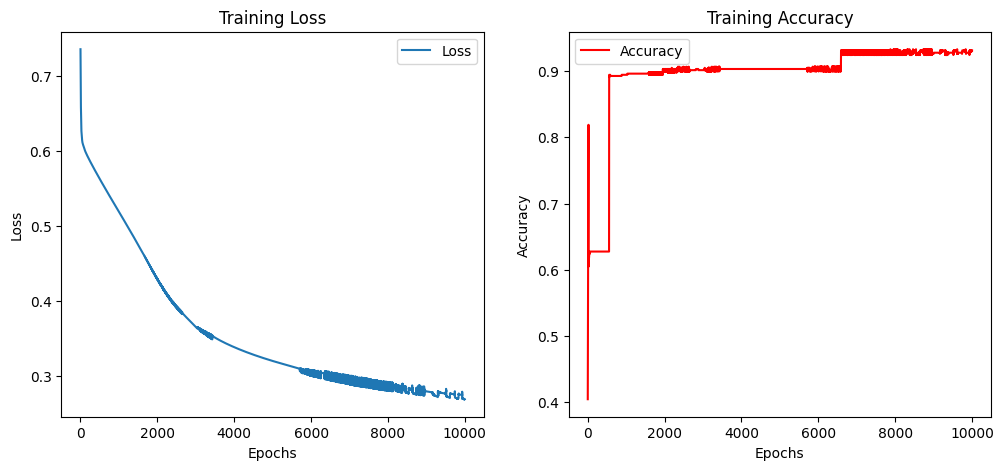

In [30]:
n_classes = y_classification.shape[1]

mlp = MLP(task="classification", hidden_layer_sizes=[20, 40, 10], activation="sigmoid", last_layer_activation="sigmoid", learning_rate=0.01, n_classes=n_classes)
mlp.train(X_classification, y_classification, epochs=10000)

Training result after 10000 epochs
Final loss: 0.0144

Complete metrics


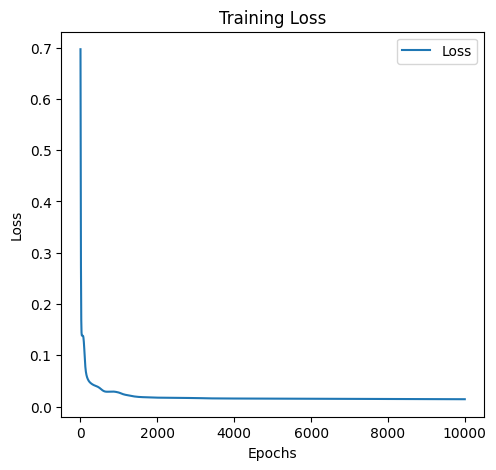

In [28]:
n_classes = y_regression.shape[1]

mlp = MLP(task="regression", hidden_layer_sizes=[10, 20, 10], activation="relu", last_layer_activation="sigmoid", learning_rate=0.01, n_classes=n_classes)
mlp.train(X_regression, y_regression, epochs=10000)